## Download Dataset

In [ ]:
!pip install -q git+https://github.com/tensorflow/docs

  Preparing metadata (setup.py) ... done


In [ ]:
!!wget -q https://github.com/sayakpaul/Action-Recognition-in-TensorFlow/releases/download/v1.0.0/ucf101_top5.tar.gz
!tar xf ucf101_top5.tar.gz

### Prepare Data

In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

def prepare_dataset(files_path, sequence_length=19, width=64, height=64, channels=1, test_size=0.2, random_state=42):
    """
    Processes .avi video files in the specified directory and returns training and validation datasets.

    Each sample consists of:
        - x: First 19 frames
        - y: Next 19 frames

    Args:
        files_path (str): Path to the directory containing .avi video files.
        sequence_length (int): Number of frames per sequence (both for x and y).
        width (int): Desired frame width after resizing.
        height (int): Desired frame height after resizing.
        channels (int): Number of color channels (1 for grayscale, 3 for RGB).
        test_size (float): Proportion of the dataset to include in the validation split.
        random_state (int): Seed used by the random number generator.

    Returns:
        tuple: x_train, y_train, x_val, y_val
            - x_train: np.ndarray of shape (train_samples, sequence_length, height, width, channels)
            - y_train: np.ndarray of shape (train_samples, sequence_length, height, width, channels)
            - x_val: np.ndarray of shape (val_samples, sequence_length, height, width, channels)
            - y_val: np.ndarray of shape (val_samples, sequence_length, height, width, channels)
    """

    def load_video_frames(video_path):
        """
        Loads video frames, converts to grayscale or RGB, resizes, and normalizes.

        Args:
            video_path (str): Path to the .avi video file.

        Returns:
            np.ndarray: Array of processed frames with shape (num_frames, height, width, channels)
        """
        cap = cv2.VideoCapture(video_path)
        frames = []
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            try:
                if channels == 1:
                    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                    frame = frame[:, :, np.newaxis]  # Add channel dimension
                else:
                    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frame = cv2.resize(frame, (width, height))
                frame = frame.astype("float32") / 255.0  # Normalize to [0, 1]
                frames.append(frame)
            except Exception as e:
                print(f"Error processing frame in {video_path}: {e}")
                continue
        cap.release()
        frames = np.array(frames)
        # Ensure frames have 4 dimensions
        if channels == 1 and frames.ndim == 3:
            frames = frames[..., np.newaxis]
        return frames  # Shape: (num_frames, height, width, channels)

    def extract_sequences(frames, sequence_length):
        """
        Splits the frames into input (x) and target (y) sequences.

        Args:
            frames (np.ndarray): Array of frames with shape (num_frames, height, width, channels)
            sequence_length (int): Number of frames per sequence.

        Returns:
            list of tuples: Each tuple contains (x_sequence, y_sequence)
        """
        sequences = []
        total_length = 2 * sequence_length
        num_frames = frames.shape[0]

        # Slide a window over the frames to extract sequences
        for start in range(0, num_frames - total_length + 1, sequence_length):
            x_seq = frames[start:start + sequence_length]
            y_seq = frames[start + sequence_length:start + total_length]
            sequences.append((x_seq, y_seq))

        # Handle the last set of frames if not enough for a full sequence
        if num_frames >= total_length:
            remaining = num_frames - total_length
            if remaining > 0:
                x_seq = frames[-2 * sequence_length:-sequence_length]
                y_seq = frames[-sequence_length:]
                sequences.append((x_seq, y_seq))

        return sequences

    # Gather all .avi files
    video_files = [f for f in os.listdir(files_path) if f.lower().endswith('.avi')]
    if not video_files:
        raise ValueError(f"No .avi files found in the directory: {files_path}")

    print(f"Found {len(video_files)} video files.")

    # Initialize lists to hold input and target sequences
    x_data = []
    y_data = []

    for idx, video_file in enumerate(video_files):
        video_path = os.path.join(files_path, video_file)
        frames = load_video_frames(video_path)

        if frames.size == 0:
            print(f"Warning: No frames found in video {video_file}. Skipping.")
            continue

        if frames.ndim != 4:
            print(f"Warning: Unexpected frame dimensions {frames.shape} in video {video_file}. Skipping.")
            continue

        sequences = extract_sequences(frames, sequence_length)

        if not sequences:
            print(f"Warning: Not enough frames for sequences in video {video_file}. Skipping.")
            continue

        for seq_idx, (x_seq, y_seq) in enumerate(sequences):
            # If sequences are shorter than required, pad them
            if x_seq.shape[0] < sequence_length:
                pad_width = sequence_length - x_seq.shape[0]
                x_pad = np.zeros((pad_width, height, width, channels), dtype="float32")
                x_seq = np.concatenate((x_seq, x_pad), axis=0)

            if y_seq.shape[0] < sequence_length:
                pad_width = sequence_length - y_seq.shape[0]
                y_pad = np.zeros((pad_width, height, width, channels), dtype="float32")
                y_seq = np.concatenate((y_seq, y_pad), axis=0)

            x_data.append(x_seq[:sequence_length])
            y_data.append(y_seq[:sequence_length])

        if (idx + 1) % 100 == 0 or (idx + 1) == len(video_files):
            print(f"Processed {idx + 1}/{len(video_files)} videos.")

    x_data = np.array(x_data)  # Shape: (num_samples, sequence_length, height, width, channels)
    y_data = np.array(y_data)  # Shape: (num_samples, sequence_length, height, width, channels)

    print(f"Total sequences extracted: {x_data.shape[0]}")

    # Split the dataset into training and validation sets
    x_train, x_val, y_train, y_val = train_test_split(
        x_data, y_data, test_size=test_size, random_state=random_state
    )

    print(f"Training Dataset Shapes: {x_train.shape}, {y_train.shape}")
    print(f"Validation Dataset Shapes: {x_val.shape}, {y_val.shape}")

    return x_train, y_train, x_val, y_val

### Check Data Dimensions

In [ ]:
# Path to the 'train' directory containing .avi files
files_path = "train"  # Replace with your actual path

# Prepare the dataset
x_train, y_train, x_val, y_val = prepare_dataset(files_path)

# Inspect the dataset shapes
print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
print("Validation Dataset Shapes: " + str(x_val.shape) + ", " + str(y_val.shape))

Found 594 video files.
Processed 100/594 videos.
Processed 200/594 videos.
Processed 300/594 videos.
Processed 400/594 videos.
Processed 500/594 videos.
Processed 594/594 videos.
Total sequences extracted: 5950
Training Dataset Shapes: (4760, 19, 64, 64, 1), (4760, 19, 64, 64, 1)
Validation Dataset Shapes: (1190, 19, 64, 64, 1), (1190, 19, 64, 64, 1)
Training Dataset Shapes: (4760, 19, 64, 64, 1), (4760, 19, 64, 64, 1)
Validation Dataset Shapes: (1190, 19, 64, 64, 1), (1190, 19, 64, 64, 1)


## Data Visualization

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_random_samples(x_train, num_samples=5):
    """
    Plots random samples from the dataset in a grid.

    Args:
        x_train (numpy.ndarray): Array of shape (num_samples, sequence_length, height, width, channels)
        num_samples (int, optional): Number of random samples to plot. Defaults to 5.

    Raises:
        ValueError: If num_samples is greater than the number of available samples in x_train.
    """
    total_samples = x_train.shape[0]
    sequence_length = x_train.shape[1]
    height = x_train.shape[2]
    width = x_train.shape[3]
    channels = x_train.shape[4]

    if num_samples > total_samples:
        raise ValueError(f"num_samples ({num_samples}) is greater than the total number of samples ({total_samples}).")

    # Randomly select unique sample indices
    random_indices = np.random.choice(total_samples, size=num_samples, replace=False)

    # Create a figure with num_samples rows and sequence_length columns
    fig, axes = plt.subplots(num_samples, sequence_length, figsize=(sequence_length * 1.2, num_samples * 1.2))

    # If only one sample is plotted, axes will not be a 2D array
    if num_samples == 1:
        axes = np.expand_dims(axes, axis=0)

    for row_idx, sample_idx in enumerate(random_indices):
        for frame_idx in range(sequence_length):
            ax = axes[row_idx, frame_idx]
            frame = x_train[sample_idx, frame_idx, :, :, 0]  # Extract the single channel

            # Display the frame
            ax.imshow(frame, cmap='gray')
            ax.axis('off')

        # Add a title to the first frame of each row
        axes[row_idx, 0].set_title(f"Sample {sample_idx}", fontsize=10)

    plt.tight_layout()
    plt.show()

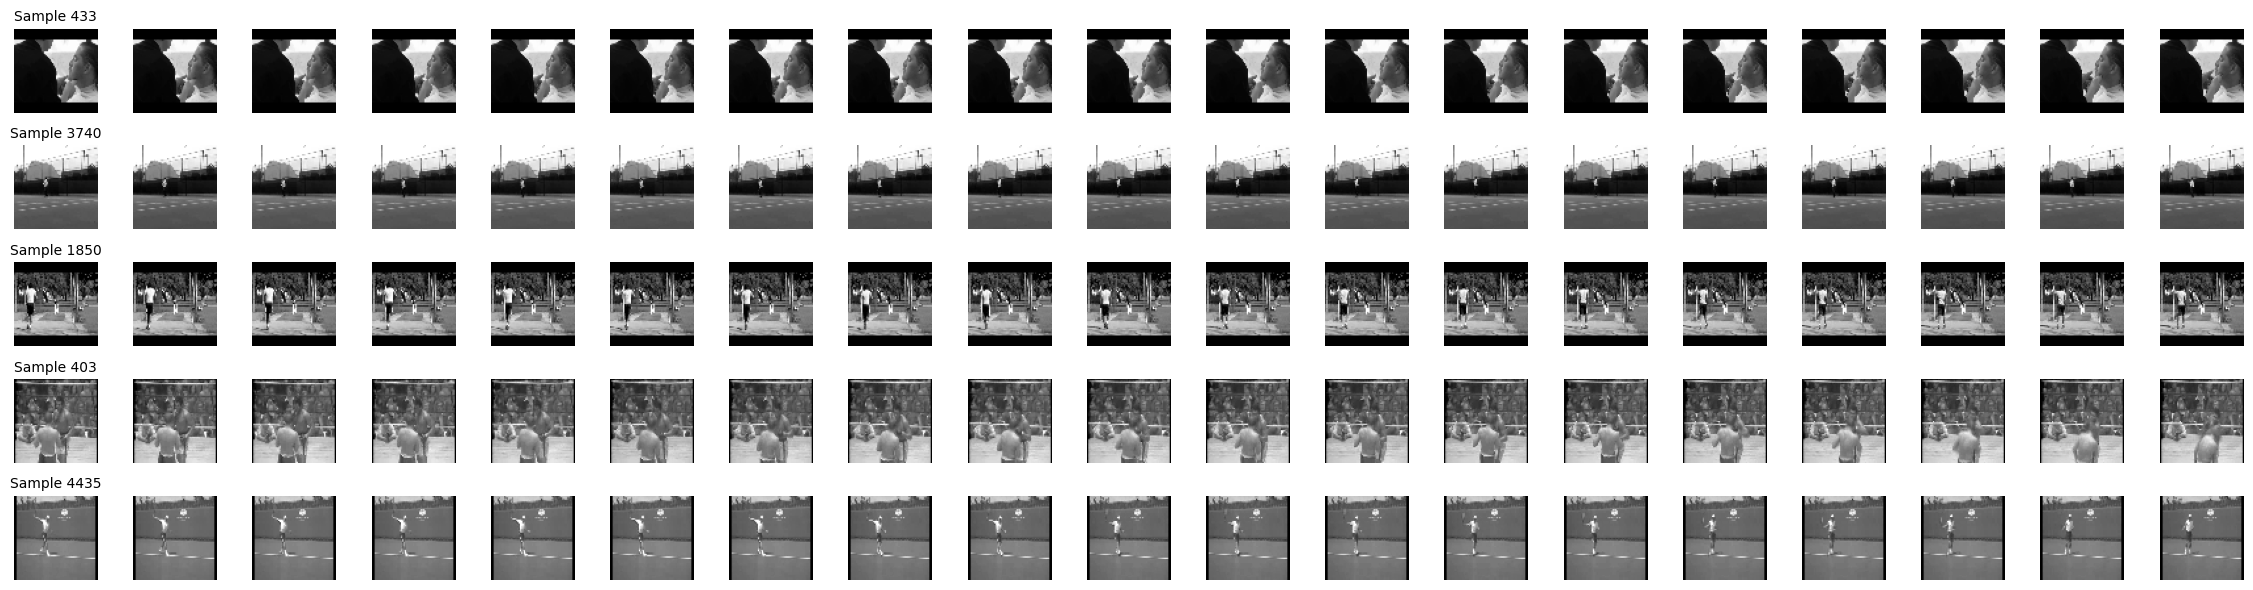

In [ ]:
# Plot 5 random samples
plot_random_samples(x_train, num_samples=5)

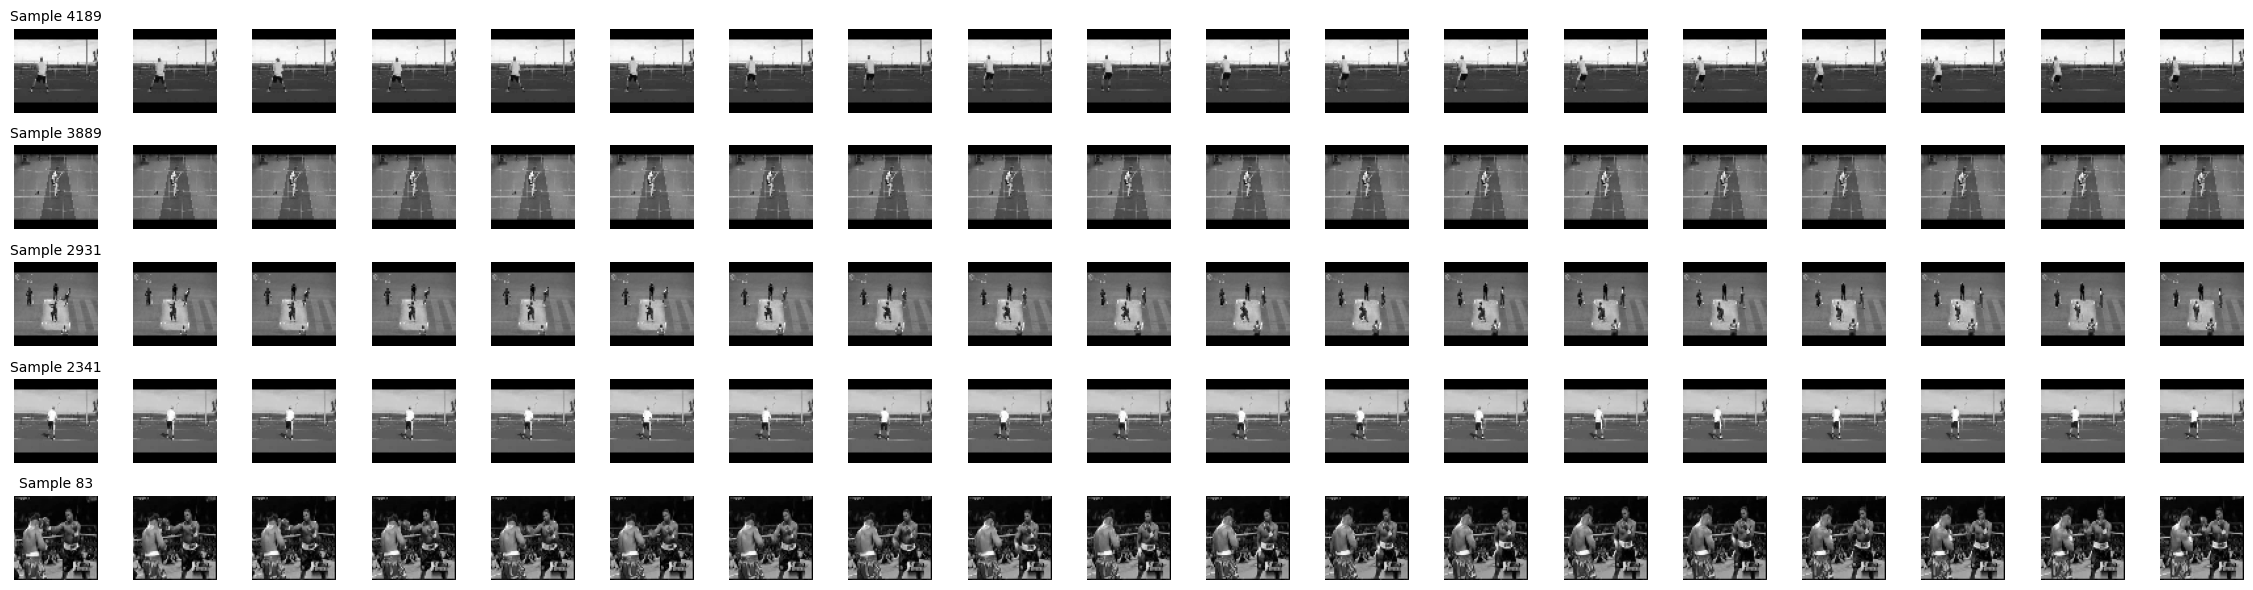

In [ ]:
# Plot 5 random samples
plot_random_samples(y_train, num_samples=5)

## Path to Save

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

In [ ]:
os.chdir("/content/drive/MyDrive/VAPAAD/output")

In [ ]:
from datetime import datetime

def datetime_to_string(dt: datetime) -> str:
    """
    Convert a datetime object to a string in the format YYYY_MM_DD.

    Parameters:
    dt (datetime): The datetime object to convert.

    Returns:
    str: The formatted date string.
    """
    return dt.strftime("%Y_%m_%d")

# Example usage
current_datetime = datetime.now()
formatted_date = datetime_to_string(current_datetime)
print(formatted_date)

2024_12_20


## Define Model

In [ ]:
from typing import Optional, Tuple, Union
import tensorflow as tf
from tensorflow.keras import layers, regularizers
from tensorflow.keras.layers import Conv2D

class CustomConv2D(Conv2D):
    """
    A custom 2D convolution layer that applies a softmax activation
    along the channel dimension after performing the convolution.

    This layer inherits from `tf.keras.layers.Conv2D` and overrides the
    `call` method to pass the convolution output through a softmax function.

    Args:
        filters: Integer, the dimensionality of the output space
                 (i.e. the number of filters in the convolution).
        kernel_size: An integer or tuple/list of 2 integers, specifying the
                     height and width of the 2D convolution window.
        strides: An integer or tuple/list of 2 integers, specifying the strides
                 of the convolution along the height and width.
                 (default: (1, 1))
        padding: One of "valid" or "same" (case-insensitive).
                 (default: "valid")
        data_format: A string, one of "channels_last" or "channels_first".
                     (default: "channels_last")
        dilation_rate: An integer or tuple/list of 2 integers, specifying
                       the dilation rate to use for dilated convolution.
                       (default: (1, 1))
        activation: Activation function not needed here as we will apply softmax
                    manually.
        use_bias: Boolean, whether the layer uses a bias vector.
                  (default: True)
        kernel_initializer: Initializer for the kernel weights matrix.
        bias_initializer: Initializer for the bias vector.
        kernel_regularizer: Regularizer function applied to the kernel weights matrix.
        bias_regularizer: Regularizer function applied to the bias vector.
        activity_regularizer: Regularizer function applied to the output of the layer.
        kernel_constraint: Constraint function applied to the kernel matrix.
        bias_constraint: Constraint function applied to the bias vector.
    """

    def call(self, inputs: tf.Tensor) -> tf.Tensor:
        """
        Call method that performs the convolution and then applies a softmax
        along the channel dimension.

        Args:
            inputs: A 4D tensor with shape
                    (batch_size, height, width, channels) if data_format='channels_last'.

        Returns:
            A 4D tensor of the same shape as `inputs`, after the convolution
            and softmax activation.
        """
        # Perform the standard convolution
        x = super().call(inputs)
        # Apply softmax along the channel dimension
        # Assuming channels_last format, softmax is applied along axis = -1
        x = tf.nn.softmax(x, axis=-1)
        return x

In [ ]:
from tensorflow.keras import layers, models, optimizers, losses, regularizers
import tensorflow as tf

def naive_spatial_attention(inputs: tf.Tensor) -> tf.Tensor:
    """
    Applies a naive spatial attention by averaging across spatial dimensions
    and using a dense layer to produce a spatial attention map.
    """
    attention = layers.GlobalAveragePooling3D()(inputs)
    attention = layers.Dense(1, activation='sigmoid')(attention)
    return layers.multiply([inputs, attention])

class PatchEmbeddingLayer(layers.Layer):
    """
    A custom layer that applies a convolution to emulate patch extraction,
    and then applies a learnable embedding projection (another convolution)
    to produce a trainable embedded representation.

    This layer:
    - Takes input of shape (b, t, h, w, c).
    - Applies a TimeDistributed Conv2D to extract patch-like features.
    - Applies a TimeDistributed 1x1 Conv2D to produce a trainable embedding.
    - Outputs (b, t, h, w, filters).
    """

    def __init__(self, filters: int = 48, kernel_size: int = 5, **kwargs):
        super().__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        # These will be built once input shape is known
        self.patch_conv = None
        self.embedding_conv = None

    def build(self, input_shape):
        # input_shape is (b, t, h, w, c)
        # We'll create patch-based convolution: a small kernel to emulate patch extraction
        # Here, kernel_size=5 is arbitrary; you can adjust as needed.
        self.patch_conv = layers.TimeDistributed(
            CustomConv2D(
                filters=self.filters,
                kernel_size=(self.kernel_size, self.kernel_size),
                padding='same',
                activation='relu',
                kernel_regularizer=regularizers.l2(1e-5)
            )
        )

        # Another TimeDistributed Conv2D with kernel_size=1 to act as a learnable embedding
        self.embedding_conv = layers.TimeDistributed(
            CustomConv2D(
                filters=self.filters,
                kernel_size=(1, 1),
                activation='linear',
                kernel_regularizer=regularizers.l2(1e-5)
            )
        )
        super().build(input_shape)

    def call(self, x: tf.Tensor) -> tf.Tensor:
        # x: (b, t, h, w, c)
        x = self.patch_conv(x)      # (b, t, h, w, filters)
        x = self.embedding_conv(x)  # (b, t, h, w, filters)
        return x

def build_model(input_shape: tuple[int, int, int, int, int], num_spatial_block: int = 2) -> tf.keras.Model:
    """
    Builds a model for next frame prediction using a U-Net style architecture.
    Instead of ConvLSTM2D, we use a PatchEmbeddingLayer that applies a convolution
    to extract patch-like features and then a trainable embedding projection.

    Args:
        input_shape: (time, height, width, channels).
        num_spatial_block: Number of spatial blocks in the encoder and decoder.

    Returns:
        A Keras Model object.
    """
    inp = layers.Input(shape=input_shape)

    encoder_outputs = []
    x = inp
    for i in range(num_spatial_block):
        # Use PatchEmbeddingLayer instead of ConvLSTM2D
        x = PatchEmbeddingLayer(filters=48, kernel_size=5)(x)
        x = naive_spatial_attention(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.2)(x)
        encoder_outputs.append(x)

    # Bottleneck layer (using PatchEmbeddingLayer instead of ConvLSTM2D)
    x = PatchEmbeddingLayer(filters=64, kernel_size=5)(x)
    x = naive_spatial_attention(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    # Decoder path
    for i in reversed(range(num_spatial_block)):
        x = PatchEmbeddingLayer(filters=48, kernel_size=5)(x)
        x = layers.BatchNormalization()(x)
        x = layers.Concatenate()([x, encoder_outputs[i]])
        x = layers.Dropout(0.2)(x)

    # Final Conv3D layer for spatiotemporal output
    x = layers.Conv3D(
        filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
    )(x)

    model = models.Model(inputs=inp, outputs=x)
    return model

In [ ]:
input_dim = list(x_train.shape)
output_dim = list(y_train.shape)
print(f"Input dimension: {input_dim}")
print(f"Output dimension: {output_dim}")

input_dim_str = [input_dim[i] for i in range(len(input_dim))]
output_dim_str = [output_dim[i] for i in range(len(output_dim))]
print(f"Input dimension: {input_dim_str}")
print(f"Output dimension: {output_dim_str}")

input_dim = "_".join(map(str, input_dim_str))
output_dim = "_".join(map(str, output_dim_str))
print(f"Input dimension: {input_dim}")
print(f"Output dimension: {output_dim}")

Input dimension: [4760, 19, 64, 64, 1]
Output dimension: [4760, 19, 64, 64, 1]
Input dimension: [4760, 19, 64, 64, 1]
Output dimension: [4760, 19, 64, 64, 1]
Input dimension: 4760_19_64_64_1
Output dimension: 4760_19_64_64_1


### Training

In [ ]:
import keras

In [ ]:
%%time

# Define model: vid2vid
num_spatial_block = 3
model = build_model(input_shape=(None, *x_train.shape[2:]), num_spatial_block=num_spatial_block)

# Compile
lr = 1e-4
wd = 1e-4
cv = 1.0
optimizer = optimizers.AdamW(learning_rate=lr, weight_decay=wd, clipvalue=cv)
model.compile(
    loss=losses.binary_crossentropy,
    optimizer=optimizer,
)

# Define some callbacks to improve training.
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=100)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.9, patience=3, verbose=1)

# Define modifiable training hyperparameters.
epochs = 100
batch_size = 2

# with tf.device('/device:GPU:0'):
# Fit the model to the training data.
model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, reduce_lr],
)

Epoch 1/100
2380/2380 ━━━━━━━━━━━━━━━━━━━━ 840s 325ms/step - loss: 0.5979 - val_loss: 0.5085 - learning_rate: 1.0000e-04
Epoch 2/100
2380/2380 ━━━━━━━━━━━━━━━━━━━━ 753s 316ms/step - loss: 0.5229 - val_loss: 0.5045 - learning_rate: 1.0000e-04
Epoch 3/100
2380/2380 ━━━━━━━━━━━━━━━━━━━━ 753s 316ms/step - loss: 0.5236 - val_loss: 0.5022 - learning_rate: 1.0000e-04
Epoch 4/100
2380/2380 ━━━━━━━━━━━━━━━━━━━━ 749s 315ms/step - loss: 0.5184 - val_loss: 0.5015 - learning_rate: 1.0000e-04
Epoch 5/100
2380/2380 ━━━━━━━━━━━━━━━━━━━━ 747s 314ms/step - loss: 0.5215 - val_loss: 0.5012 - learning_rate: 1.0000e-04
Epoch 6/100
2380/2380 ━━━━━━━━━━━━━━━━━━━━ 746s 314ms/step - loss: 0.5194 - val_loss: 0.5018 - learning_rate: 1.0000e-04
Epoch 7/100
2380/2380 ━━━━━━━━━━━━━━━━━━━━ 746s 313ms/step - loss: 0.5218 - val_loss: 0.5001 - learning_rate: 1.0000e-04
Epoch 8/100
2380/2380 ━━━━━━━━━━━━━━━━━━━━ 745s 313ms/step - loss: 0.5169 - val_loss: 0.5002 - learning_rate: 1.0000e-04
Epoch 9/100
2380/2380 ━━━━━━━━━━

### Save Performance

In [ ]:
import pandas as pd

In [ ]:
model_name = "custom_custom_conv2d_design_ucf101_dataset"
file_name = f"model_info_{model_name}_{formatted_date}_numblock_{num_spatial_block}_epochs_{epochs}_batch_{batch_size}_lr_{lr}_wd_{wd}_cv_{cv}_history_inputseq_{input_dim}_and_outputseq_{output_dim}"
print(f"File name: {file_name}")

File name: model_info_custom_custom_conv2d_design_ucf101_dataset_2024_12_20_numblock_1_epochs_100_batch_2_lr_0.001_wd_0.0001_cv_1.0_history_inputseq_4760_19_64_64_1_and_outputseq_4760_19_64_64_1


In [ ]:
try:
    if True:
        pd.DataFrame(model.history.history).to_csv(f"{file_name}.csv")
except:
    print("No history found.")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import imageio.v2 as imageio
import io
from IPython.display import Image

# Assume x_train and y_train have shapes:
# x_train: (4760, 19, 64, 64, 1)
# y_train: (4760, 19, 64, 64, 1)
# We will use the first 10 frames of x_train to predict the next 9 frames,
# and compare these predictions to the corresponding frames in y_train.

# Select a few random examples from the training set.
num_samples = 5
indices = np.random.choice(range(len(x_train)), size=num_samples, replace=False)
x_examples = x_train[indices]
y_examples = y_train[indices]

# Prepare arrays to store the ground truth and predicted frames.
# Here, we have a total of 19 frames: the first 10 are inputs, the last 9 are predictions.
truth_frames = np.zeros((num_samples, 19, 64, 64, 1))
predicted_frames = np.zeros((num_samples, 19, 64, 64, 1))

# Generate predictions and store them in the tensors.
for idx, (x_ex, y_ex) in enumerate(zip(x_examples, y_examples)):
    # First 10 frames used as input
    input_frames = x_ex[:10]
    # Last 9 frames are the ground truth to be predicted
    ground_truth = y_ex[10:]

    # Container for predicted frames
    new_predictions = np.zeros((9, 64, 64, 1))

    # Predict one frame at a time, incrementally.
    # At each step, provide the model with all available frames (initially 10,
    # then adding one new predicted frame each iteration).
    frames_sequence = np.copy(input_frames)
    for i in range(9):
        # Model expects input in shape (1, T, H, W, C)
        prediction = model.predict(np.expand_dims(frames_sequence, axis=0))

        # prediction shape: (1, T, H, W, C), where T is the length of the predicted sequence
        # We only take the last predicted frame
        prediction = np.squeeze(prediction, axis=0)
        predicted_frame = np.expand_dims(prediction[-1], axis=0)

        # Store the predicted frame
        new_predictions[i] = predicted_frame

        # Append the newly predicted frame to frames_sequence for next iteration
        frames_sequence = np.concatenate([frames_sequence, predicted_frame], axis=0)

    # Store both ground truth and predictions for each sample
    # The truth_frames and predicted_frames both contain the first 10 frames from x_ex,
    # followed by either ground truth or predicted frames.
    truth_frames[idx] = np.concatenate([x_ex[:10], y_ex[10:]], axis=0)
    predicted_frames[idx] = np.concatenate([x_ex[:10], new_predictions], axis=0)

# Create GIF showing a 5x2 grid of ground truth and predictions for each frame step.
frames_list = []
for frame_idx in range(19):
    fig, axs = plt.subplots(num_samples, 2, figsize=(5, 10))
    fig.subplots_adjust(wspace=0.1, hspace=0.1)

    for row in range(num_samples):
        # True image
        axs[row, 0].imshow(truth_frames[row, frame_idx].squeeze(), cmap="gray")
        axs[row, 0].axis("off")
        if frame_idx == 0:
            axs[row, 0].set_title("Truth")

        # Predicted image
        axs[row, 1].imshow(predicted_frames[row, frame_idx].squeeze(), cmap="gray")
        axs[row, 1].axis("off")
        if frame_idx == 0:
            axs[row, 1].set_title("Prediction")

    # Add timestamp annotation
    fig.text(0.3, 0.93, f"Timestamp: t={frame_idx + 1}\nLeft: Truth, Right: Pred",
             ha="center", va="center", transform=fig.transFigure)

    # Convert figure to image and add to frames list
    buf = io.BytesIO()
    plt.savefig(buf, format="png")
    buf.seek(0)
    frames_list.append(imageio.imread(buf))
    buf.close()
    plt.close(fig)

# Save the frames list as a single GIF
with io.BytesIO() as gif:
    imageio.mimsave(f"{file_name}_pred_comparison_anno.gif", frames_list, duration=300)
    gif_bytes = gif.getvalue()


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18

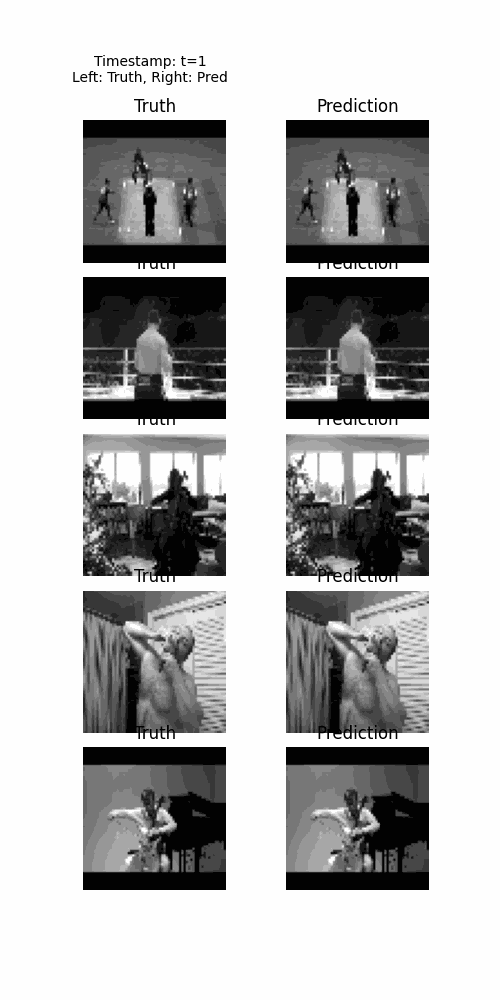

In [ ]:
# Display the GIF inline
display(Image(f"{file_name}_pred_comparison_anno.gif"))